In [1]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Metrics
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [4]:
# Data generators with rescaling
train_datagen_with_aug = ImageDataGenerator(rescale=1./255, validation_split=0.1)

train_generator = train_datagen_with_aug.flow_from_directory(
    r"C:\Users\Hardik\Desktop\DR\Dataset\aptos2019-blindness-detection\train_split",
    target_size=(224, 224),  # Resize images to a fixed size
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen_with_aug.flow_from_directory(
    r"C:\Users\Hardik\Desktop\DR\Dataset\aptos2019-blindness-detection\train_split",
    target_size=(224, 224),  # Resize images to a fixed size
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 3298 images belonging to 5 classes.
Found 364 images belonging to 5 classes.


In [6]:
# Functional API for building the model
input_img = Input(shape=(224, 224, 3))
densenet_base = DenseNet169(weights='imagenet', include_top=False, input_tensor=input_img)

# Freeze layers in DenseNet121
for layer in densenet_base.layers:
    layer.trainable = False

# Add custom layers on top of DenseNet121
x = Flatten()(densenet_base.output)
x = Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
output = Dense(5, activation='softmax')(x)

# Construct the model
model = Model(inputs=input_img, outputs=output)

# Summary of the model
# model.summary()

# Compile the model
adam = Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy', precision_m, recall_m, f1_m])

# Train the model
graph = model.fit(train_generator, epochs=25, validation_data=validation_generator)

# # Save the model
# model.save("/Users/hardikchhipa/Desktop/DR-Arvind/saved_models/used_models/densenet_121.h5")

# Print the results
print(graph.history)

51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/25


c:\Users\Hardik\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


104/104 ━━━━━━━━━━━━━━━━━━━━ 301s 3s/step - accuracy: 0.5764 - f1_m: 0.5767 - loss: 17.9702 - precision_m: 0.5847 - recall_m: 0.5698 - val_accuracy: 0.7500 - val_f1_m: 0.7403 - val_loss: 0.6919 - val_precision_m: 0.7731 - val_recall_m: 0.7109
Epoch 2/25
104/104 ━━━━━━━━━━━━━━━━━━━━ 274s 3s/step - accuracy: 0.7574 - f1_m: 0.7622 - loss: 0.7673 - precision_m: 0.7937 - recall_m: 0.7342 - val_accuracy: 0.7720 - val_f1_m: 0.7641 - val_loss: 0.6621 - val_precision_m: 0.8125 - val_recall_m: 0.7222
Epoch 3/25
104/104 ━━━━━━━━━━━━━━━━━━━━ 274s 2s/step - accuracy: 0.7694 - f1_m: 0.7687 - loss: 0.6247 - precision_m: 0.8072 - recall_m: 0.7352 - val_accuracy: 0.7747 - val_f1_m: 0.7621 - val_loss: 0.6224 - val_precision_m: 0.7930 - val_recall_m: 0.7352
Epoch 4/25
104/104 ━━━━━━━━━━━━━━━━━━━━ 275s 2s/step - accuracy: 0.7776 - f1_m: 0.7710 - loss: 0.5998 - precision_m: 0.8185 - recall_m: 0.7302 - val_accuracy: 0.7280 - val_f1_m: 0.7459 - val_loss: 0.7270 - val_precision_m: 0.8064 - val_recall_m: 0.695

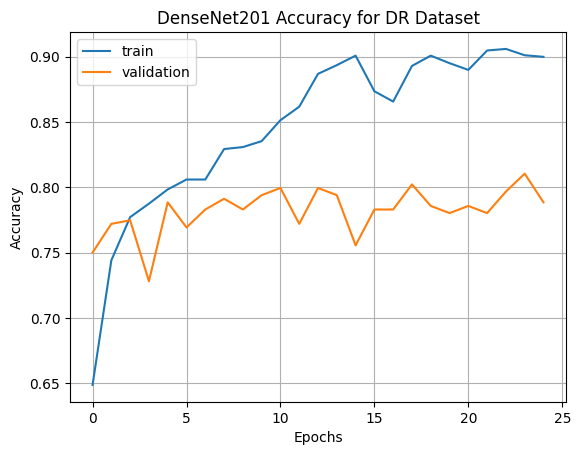

In [7]:
import matplotlib.pyplot as plt

fig1 = plt.gcf()

plt.plot(graph.history['accuracy'])
plt.plot(graph.history['val_accuracy'])

# plt.axis(ymin=0.4, ymax=1)
plt.grid()

plt.title('DenseNet201 Accuracy for DR Dataset')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train','validation'])

plt.show()